# Predicting sentiments from product reviews
The dataset used in this notebook can be found here [amazon_baby.csv](https://d396qusza40orc.cloudfront.net/phoenixassets/amazon_baby.csv)

In [1]:
import pandas as pd
import numpy as np

In [2]:
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline

Import necessary package for words preprocessing (cleaning text):
- Import re (regular expression, for removing punctuation)
- Import nltk and download stopwords corpus (remove stopwords such as "and", "the", etc)

In [3]:
import re, collections
import nltk
#nltk.download()
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
products = pd.read_csv("./data/amazon_baby.csv")

## A bit of data exploration

In [6]:
products.head(5)

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [7]:
products.count()

name      183213
review    182702
rating    183531
dtype: int64

Some reviews are obviously **missing (NaN)**. Replace NaN reviews with " " to avoid errors when processing texts later on.

In [8]:
products["review"].fillna(" ",inplace=True)

## Create bag of words for reviews

### Clean the reviews first
- Remove punctuation (using regular expression)
- Change review to lowercase only and split text in words
- (optionally remove stop words. This is not done in the course)
- Finally Put all reviews in a list (reviews)

In [9]:
def clean_review(raw_review, stopswrd):
    review = re.sub("[^a-zA-Z]"," ",raw_review)
    review = review.lower().split()
    #review = [w for w in review if not w in stopswrd]
    return(" ".join(review))

In [10]:
stopswrd = set(stopwords.words("english"))

In [11]:
reviews = []
num_reviews = products.shape[0]

In [12]:
for i in range(0,num_reviews):
    reviews.append(clean_review(products["review"][i],stopswrd))

### The bag of words
Create a data frame containing bag of words for each review and add the column to the **products** DataFrame.

In [13]:
%%time
bagofwords = pd.DataFrame((str(dict(collections.Counter(re.findall(r"\w+", txt)))) for txt in reviews),columns=["word_count"])

Wall time: 11.1 s


In [14]:
products.insert(len(products.columns),"word_count",bagofwords)

In [15]:
products.head(5)

,name,review,rating,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{'higher': 1, 'been': 1, 'rough': 1, 'them': 1..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'was': 1, 'love': 1, 'it': 3, 'disappointed':..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'fit': 1, 'bed': 1, 'anyone': 1, 'than': 1, '..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'found': 1, 'anything': 1, 'proud': 1, 'much'..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'stop': 1, 'love': 1, 'them': 4, 'headaches':..."


## Most Frequent products reviewed (top 20)

In [16]:
data = products[["name","review"]]

In [17]:
data = data.groupby("name").count().sort_values("review")
data = data.iloc[len(data)-20:len(data)]

In [18]:
#data = data.groupby("name").count().sort_values("review",ascending=False)[0:20]

In [19]:
barh_bottom = np.arange(len(data))
barh_width = data["review"]

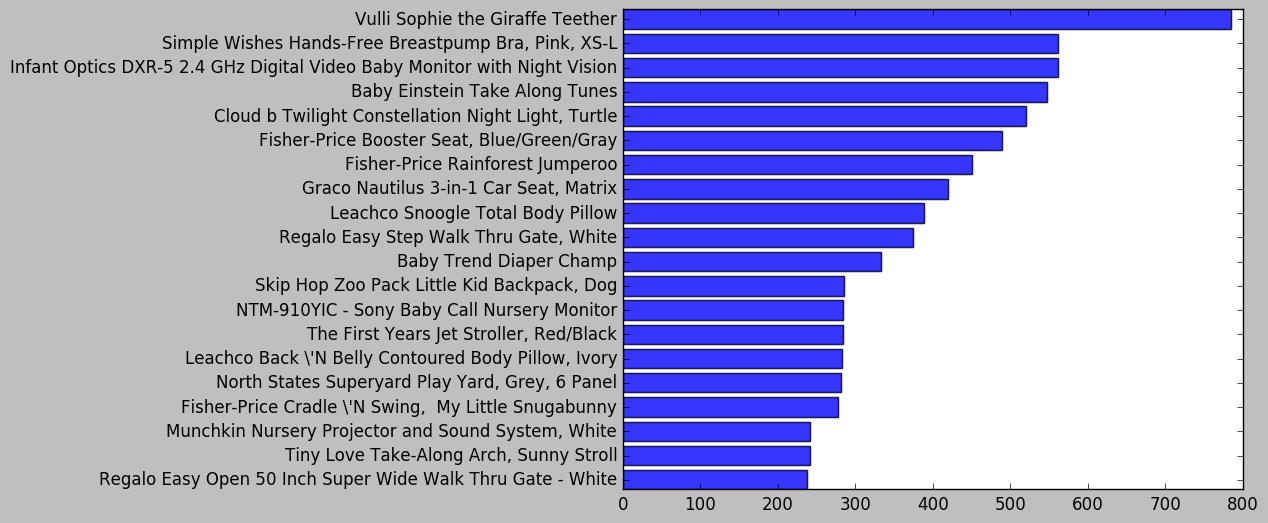

In [30]:
#plt.rcdefaults()
plt.barh(barh_bottom, barh_width, height = 0.8, align='center', alpha=0.4)
plt.yticks(barh_bottom, data.index);
plt.show()

## Exploring Vulli Sophie

In [31]:
sophie = products[products["name"] == "Vulli Sophie the Giraffe Teether"]
print("Number of review for Vulli Sophie:",sophie.shape[0])

Number of review for Vulli Sophie: 785


In [34]:
sophie["name"].groupby("rating").count()

KeyError: 'rating'

# --------

### Use sklearn then to create bag  of words
Each review will lead to a creation of a [max_features] vector holding the counts for each word of the vocabulary.

In [12]:
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

In [13]:
words_count = vectorizer.fit_transform(reviews)

words_count is a sparse matrix, it is more convenient to transform it to a numpy array.

In [14]:
words_count = words_count.toarray()
words_count.shape

(183531, 5000)

### Transform sklearn bag of words
Our bag of words is created (**words\_count** in association with the vocabulary learned by CountVectorizer instance, i.e. **vectorizer.vocabulary_**), but let's do some transformation to reproduce the course notebook (additional column with bag of words as a dictionnary for each review).

In [70]:
#def to_dict(review):
#    dic = pd.DataFrame(vectorizer.get_feature_names(), columns = ["vocabulary"])
#    dic.insert(1,"count",review.reshape(-1,1))
#    dic = dic[dic["count"]>0]
#    i = iter(dic.to_dict(orient="split")["data"])
#    return{k:v for k,v in i}

In [71]:
#%%time
#bagofwords = pd.DataFrame(words_count).apply(to_dict, axis=1)